In [8]:
from pandas import read_csv, DataFrame, concat
import tensorflow as tf
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
from math import sqrt

   time       t_db    RH  Rad        load
0   0.0   4.848381  89.0  0.0    0.000000
1   1.0   8.200627  88.5  0.0    0.000000
2   2.0  10.849464  87.5  0.0  117.851848
3   3.0  10.600000  88.0  0.0    0.000000
4   4.0  10.400000  88.5  0.0    0.000000


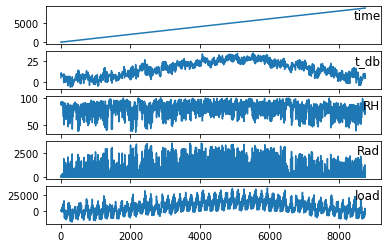

        t_db    RH  Rad        load
0   4.848381  89.0  0.0    0.000000
1   8.200627  88.5  0.0    0.000000
2  10.849464  87.5  0.0  117.851848
3  10.600000  88.0  0.0    0.000000
4  10.400000  88.5  0.0    0.000000
t_db       32.765625
RH         61.500000
Rad      2296.800293
load    36633.357843
Name: 5943, dtype: float64
t_db       -6.250000
RH         87.000000
Rad         0.000000
load   -17847.307601
Name: 319, dtype: float64


In [9]:
dataset = read_csv("load.txt", delim_whitespace=True)
values = dataset.values
print(dataset.head())
# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

dataset.drop(dataset.columns[[0]], axis=1, inplace=True)
print(dataset.head())
values = dataset.values

print(dataset.loc[dataset['load'].idxmax()])
print(dataset.loc[dataset['load'].idxmin()])

In [10]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [11]:
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
print(values)
scaled = scaler.fit_transform(values)
#scaled = values


# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5,6]], axis=1, inplace=True)
# Inputs var1 = t_db, var2 = RH, var3 = Rad, var4 = load
print(reframed.head(10))

[[ 4.84838104e+00  8.90000000e+01  0.00000000e+00  0.00000000e+00]
 [ 8.20062733e+00  8.85000000e+01  0.00000000e+00  0.00000000e+00]
 [ 1.08494644e+01  8.75000000e+01  0.00000000e+00  1.17851845e+02]
 ...
 [ 5.90000010e+00  8.55000000e+01  0.00000000e+00 -4.87477539e+03]
 [ 5.34999990e+00  8.70000000e+01  0.00000000e+00 -5.25314697e+03]
 [ 4.84999990e+00  8.90000000e+01  0.00000000e+00 -5.58237109e+03]]
    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var4(t)
1    0.273654      0.824   0.000000   0.327590  0.327590
2    0.353572      0.816   0.000000   0.327590  0.329753
3    0.416721      0.800   0.000000   0.329753  0.327590
4    0.410774      0.808   0.000000   0.327590  0.327590
5    0.406006      0.816   0.000000   0.327590  0.327590
6    0.400045      0.840   0.000000   0.327590  0.327590
7    0.394085      0.864   0.000000   0.327590  0.323247
8    0.389317      0.888   0.000000   0.323247  0.322668
9    0.389019      0.888   0.012072   0.322668  0.368116
10   0.397661      0.8

In [12]:
values = reframed.values
n_train_hours = 7000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
print(test)
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[[0.67830163 0.36       0.32796782 0.5660814  0.484698  ]
 [0.66157776 0.408      0.08148894 0.484698   0.41168362]
 [0.6420721  0.464      0.         0.41168362 0.32758975]
 ...
 [0.3118366  0.7440001  0.         0.24602643 0.23811258]
 [0.29872447 0.768      0.         0.23811258 0.23116753]
 [0.28561234 0.79200006 0.         0.23116753 0.22512457]]
(7000, 1, 4) (7000,) (1760, 1, 4) (1760,)


In [13]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(3, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(1))
opt = tf.keras.optimizers.RMSprop(0.001)
model.compile(loss='mae', optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 3)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


Train on 7000 samples, validate on 1760 samples
Epoch 1/100
7000/7000 [==============================] - 1s 127us/sample - loss: 0.3772 - val_loss: 0.2734
Epoch 2/100
7000/7000 [==============================] - 0s 26us/sample - loss: 0.2788 - val_loss: 0.2506
Epoch 3/100
7000/7000 [==============================] - 0s 24us/sample - loss: 0.2323 - val_loss: 0.2186
Epoch 4/100
7000/7000 [==============================] - 0s 28us/sample - loss: 0.1929 - val_loss: 0.1867
Epoch 5/100
7000/7000 [==============================] - 0s 25us/sample - loss: 0.1618 - val_loss: 0.1607
Epoch 6/100
7000/7000 [==============================] - 0s 24us/sample - loss: 0.1405 - val_loss: 0.1407
Epoch 7/100
7000/7000 [==============================] - 0s 27us/sample - loss: 0.1264 - val_loss: 0.1257
Epoch 8/100
7000/7000 [==============================] - 0s 23us/sample - loss: 0.1164 - val_loss: 0.1145
Epoch 9/100
7000/7000 [==============================] - 0s 26us/sample - loss: 0.1092 - val_loss: 0.10

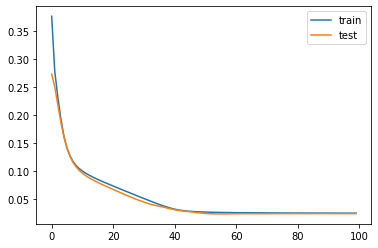

In [14]:
EPOCHS = 100
VERBOSE = 1

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(train_X, train_y, epochs=EPOCHS, 
        validation_data=(test_X, test_y), verbose=VERBOSE, 
        shuffle=False, callbacks=[early_stop], batch_size=72)

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [15]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [16]:
# invert scaling for forecast
inv_yhat = concatenate((test_X[:,[0,1,2]], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

In [17]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:,[0,1,2]], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [18]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 2027.286
Test MAE: 1275.640


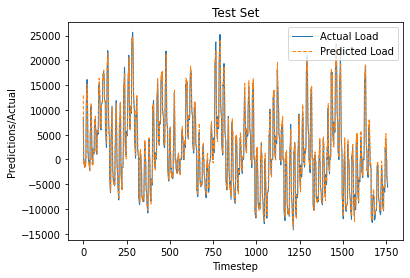

In [19]:
time = [i for i in range(len(inv_y))]
pyplot.clf()
pyplot.title("Test Set")
pyplot.xlabel('Timestep')
pyplot.ylabel('Predictions/Actual')
pyplot.rcParams['figure.figsize'] = [30, 10]
pyplot.plot(time, inv_y, label='Actual Load',linewidth=1)
pyplot.plot(time,inv_yhat, label='Predicted Load',linestyle='dashed',linewidth=1)
pyplot.legend()
pyplot.savefig('predicted.png')
pyplot.show()

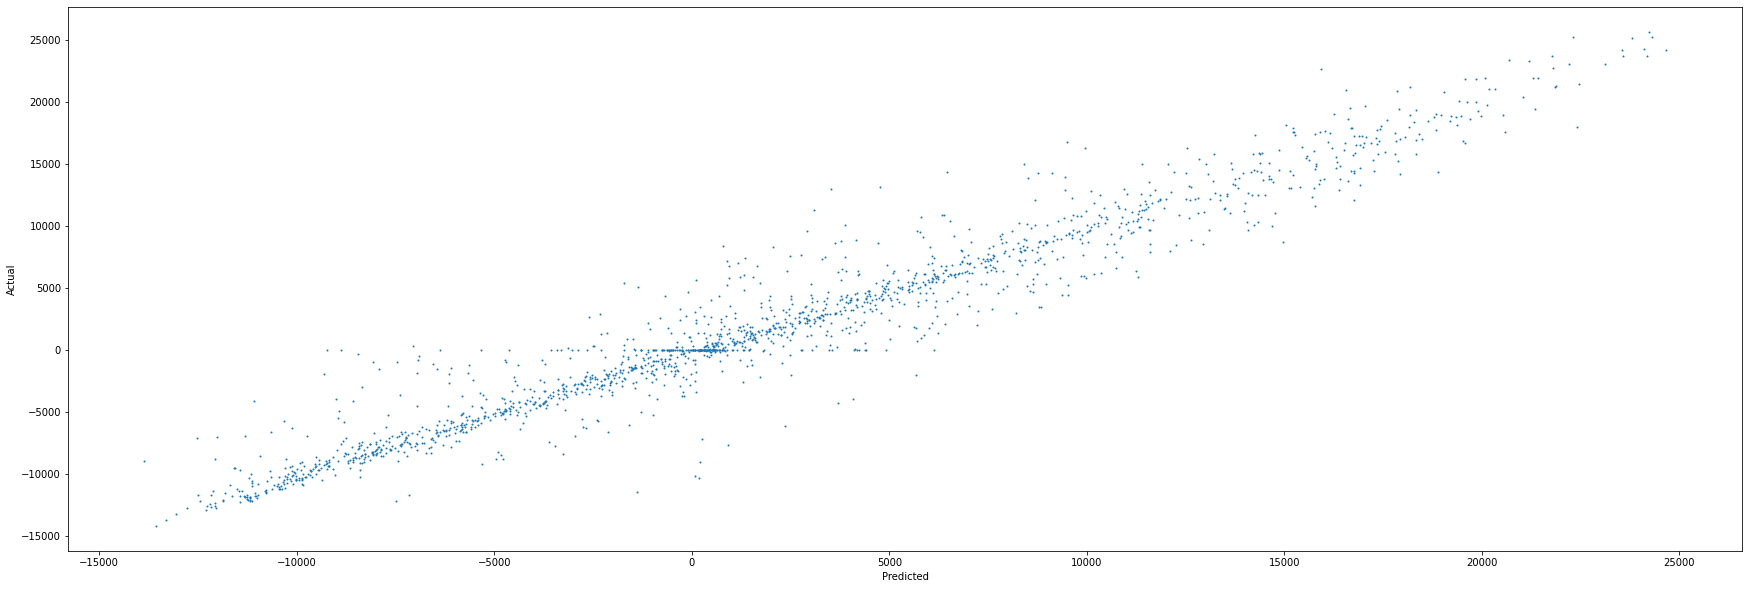

In [20]:
pyplot.clf()
pyplot.xlabel('Predicted')
pyplot.ylabel('Actual')
pyplot.scatter(inv_yhat, inv_y, s=1)
#_ = pyplot.plot([-4000,4000], [-4000,4000])
pyplot.show()
